# <center> Lecture 9: Ensemble Methods II - Stacking </center>

We have a classification problem of identifying the wine class label based on its chemical analysis of wine grown in the same region. 
We are going to use emsemble methods (Bagging, RandomForest, Boosting techniques, and stacking technique) to improve the model. 
You can visit here - https://archive.ics.uci.edu/ml/datasets/wine - for the details on data. 

## Motivation
Recall Ensemble Method I lecture, we learned that we can overcome the limitations the decision tree (DT) has by creating $n$-trees either by using subsamples or subtrees:

- reduce variance (Random Forest) 
- reduce bias (boosting)

Random Forest:
- Pros – robust to outliers, non-linear data, runs efficiently, and prevents over-fitting unlike DT
- Cons – high bias for categorical features, slow training process, not sufficient for linear methods with a lot of sparse features

Boosting:
- Pros – easy to handle, many technique choices, prevents over-fitting, better results
- Cons – sensitive to outliers, often ignores variance issues, expensive computational cost

Question $-$ Is it possible make a model that **learns from different learnings?**
- In RF, we learn by aggregating learnings from different subsamples
- In Boosting, we learn by updating previous learnings. 
- They are both tree-based. What is going to happend if we aggregate learns from different bases of models. For example, $h(h_{svm},h_{LR},h_{DT})=?$
    - this technique is called **stacking**. 

## Metalearning
**Meta learning** is
- Also known as ***learning to learn***
- Used to improve the results and performance of a learning algorithm by changing some aspects of the learning algorithms based on experiment results

**Meta learning** is useful for
- large training datasets
- when high computational costs are required due to many trials/experiments during the training phase
- when it is hard to find the best model which performs the best for a particular dataset

In last 5 years, meta learning accelerated growing, thanks to deep learning and advanced machine learning researches. 

A meta learning algorithm is **trained with outputs** and metadata of machine learning algorithms. 
Its skills gets tested before making the final predictions and tasks we can do such as 
- Observations of different ML models’ performances
- Learning from meta data
- Faster learning process for a new task. 

With an annotated data set, 
1. Various ML models are built
2. Use meta training process is used to improve the performance of these models
3. Build a new model from examples learned from the previous training process

<img src="metalearning_1.png" width="500">

Four different approaches: 
- Metric Learning – learning a metric space for predictions
- Model-Agnostic Meta Learning (MAML) – a general optimization and task-agnostic algorithm to train the parameters of a model for faster learning with small number of updates, e.g., neural network
- Recurrent Neural Networks (RNNs) – a type of artificial neural networks frequently applied for time series, natural language process, etc. 
- **Stacking/stacked generalization** – a subfield of ensemble learning used in meta learning models. 




## Stacking

- Stacking is used 
    - To learn the best combination of predictions from multiple ML algorithms
    - To optimize the prediction than using a single ML algorithm
- With a given data set, 
    - We can use many different ML algorithms that are suitable for the data set. 
    - Considering advantages and disadvantages of trained models, how do we choose the best one?
- Why not bagging? 
    - Bagging uses the samples of the training dataset. 
    - Different models are used to fit on the same training dataset. 
- Why not boosting?
    - Boosting uses a sequence of models that corrects the prediction from the previous model by updating the learner (a weak learner to a strong learner)
- Use a single model to learn the best combination of predictions from the contributed models  

### Models
<img src="stacking_01.png" width="500">

<u>Level-0 Models</u>
- individual ML algorithms are used to fit on training data
- Also called *Base-Models*
- Base models are complex and diverse – it is good to use wide ranges of models that make different assumptions and conditions to solve the problem. 
    - For regression – linear regression, decision trees, neural networks, random forest, etc. 
    - For classification – logistic regression, SVM, KNN, …. 

<u>Level-1 Model</u>
- A model that learns the combination from the predictions made by models on out-of-sample data (can considered as a test set). 
- Also called *Meta-Model*
- A meta model – keep it simple to provide a smooth interpretation of the predictions made from base models. Having a linear model is highly recommended. 
    - For regression – linear regression
    - For classification – logistic regression or SVM

#### Stacking base models to a meta model
The meta model $H=\{h_1,\dots,h_N\}$ where $h_i$ is an individual base models:
$$ \sum_{i=1}^Nw_ih_i(x_i,y_i)$$
To make the final prediction better, we can
- Include inputs to the base models to have the best combined predictions.
<img src="stacking_02.png" width="400"/>
- Use k-fold CV for base models and aggregate them.  
<img src="stacking_03.png" width="400"/> 
- Increase the levels.
<img src="stacking_04.png" width="600"/> 

### Algorithm
1. Train Data $D=\{x_i,y_i\}_{i=1}^m$
1. Step 1: build $N$ base models $h_0=\{h_1,h_2,\dots,h_N\}$
1. for $i=1$ to N do
    1. build $h_i$ based on $D$
1. end
1. Step 2: construct new data set of predictions
1. for $j=1$ to $m$ do
    1. $D_h=\{x_j',y_j\}$ where $x_i'=\{h_1(x_j),\dots,h_N(x_j)\}$
1. end
1. Step 3: build a meta model
1. build $H$ based on $D_h$
1. return $H$

In [7]:
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

## 1. Train data
We create a binary classification data set (1000 by 20) using `make_classification`. 


In [8]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.columns = ['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols',
                    'Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline']

In [9]:
y=df_wine['Class label']
X=df_wine.drop('Class label',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1,stratify=y)

## 2. Base Models


In [10]:
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['DT'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    return models

In [11]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [12]:
models = get_models()

In [13]:
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.946 (0.065)
>knn 0.666 (0.119)
>DT 0.896 (0.086)
>svm 0.717 (0.117)


The train model with logistic regression is significantly better than other classifiers indicating that the data is a linear-data and therefore, it is not necessary to do staking. However, let's observe how stacking can improve the classification if we do not include the logistic regression. Any linear models can be used for level 1 mdoel. 

In level 1 model, I used logistic regression.

In [14]:
def get_stacking():
    # define the base models
    level0 = list()
    #level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('DT', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [23]:
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['DT'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['stacking'] = get_stacking()
    return models

In [24]:
models = get_models()

In [25]:
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.950 (0.055)
>knn 0.710 (0.094)
>DT 0.891 (0.089)
>svm 0.687 (0.096)
>stacking 0.904 (0.073)


Note that the accuracy with stacking is better than KNN, DT, and SVM but still logistic regression resulted better. 

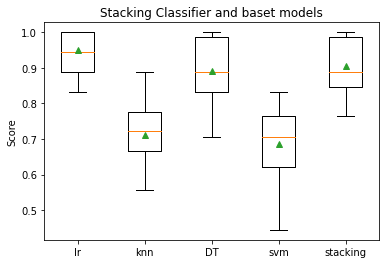

In [26]:
pyplot.figure(facecolor='white')
pyplot.boxplot(results, labels=names, showmeans=True)

pyplot.ylabel('Score')
pyplot.title('Stacking Classifier and baset models')
pyplot.show()

## 2. Prediction

In [19]:
model = get_stacking()
model.fit(X_test,y_test)

StackingClassifier(cv=5,
                   estimators=[('knn', KNeighborsClassifier()),
                               ('DT', DecisionTreeClassifier()),
                               ('svm', SVC())],
                   final_estimator=LogisticRegression())

In [20]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print('Accuracy',accuracy_score(y_test,y_pred))

Accuracy 0.9444444444444444


In [21]:
LR = LogisticRegression()
LR.fit(X_train,y_train)
print('Accuracy',accuracy_score(y_train,LR.predict(X_train)))
print('Accuracy',accuracy_score(y_test,LR.predict(X_test)))

Accuracy 0.971830985915493
Accuracy 0.8888888888888888


/Users/insukjang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
svc = SVC()
svc.fit(X_train,y_train)
print('Accuracy',accuracy_score(y_train,svc.predict(X_train)))
print('Accuracy',accuracy_score(y_test,svc.predict(X_test)))

Accuracy 0.7323943661971831
Accuracy 0.6111111111111112


## Summary

Advantage? 
- Higher model prediction accuracy
- A faster, cheaper training process
- Builds many generalized models

Disadvantage?
- Sometimes full understandings of models are not possible
- There are many ML algorithms to use…
- Overfitting 